In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import revsic_glowtts as glowtts
import numpy as np

2022-09-03 23:17:51.084274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/husein/tf-nvidia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [4]:
input_ids = tf.placeholder(tf.int32, [None, None], name = 'input_ids')
lens = tf.placeholder(tf.int32, [None], name = 'lens')
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
temperature = tf.placeholder(tf.float32, shape=(), name = 'temperature')
length_scale = tf.placeholder(tf.float32, shape=(), name = 'length_ratio')

In [5]:
config = glowtts.Config(mel = 80, vocabs = len(MALAYA_SPEECH_SYMBOLS))
config.temperature = temperature
config.length_scale = length_scale

In [6]:
model = glowtts.Model(config)

In [7]:
instance = malaya_speech.train.model.revsic_glowtts.flow.actnorm.ActNorm

for k in range(len(model.decoder.flows)):
    if isinstance(model.decoder.flows[k], instance):
        model.decoder.flows[k].init = 1

In [8]:
loss, losses, attn = model.compute_loss(text = input_ids, 
                                        textlen = lens, 
                                        mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [9]:
mel, mellen, attn_out = model(inputs = input_ids, lengths = lens)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
mel = tf.identity(mel, name = 'mel_output')
attn_out = tf.identity(attn_out, name = 'alignment_histories')

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

2022-09-04 10:22:41.526027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-04 10:22:41.559665: E tensorflow/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-04 10:22:41.559709: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2022-09-04 10:22:41.559717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2022-09-04 10:22:41.559842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-09-04 10:22:41.559872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-09-04 10:22:41.559878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-09-04 10:22:41.568148: I tensorflow/core/platf

In [12]:
path = 'glowtts-yasmin'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'glowtts-yasmin/model.ckpt-150000'

In [13]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)


INFO:tensorflow:Restoring parameters from glowtts-yasmin/model.ckpt-150000


In [14]:
import re
from unidecode import unidecode
import malaya

pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    if string[-1] in ['-', ',']:
        string = string[:-1]
    if string[-1] != '.':
        string = string + '.'
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [15]:
import matplotlib.pyplot as plt

In [17]:
from malaya_speech.utils.constant import MEL_MEAN, MEL_STD

mel_stat = np.load('../speech-bahasa/yasmin-stats/stats.npy')
vocoder = malaya_speech.vocoder.melgan()

In [18]:
# https://umno-online.my/2020/12/28/isu-kartel-daging-haram-lagi-pihak-gesa-kerajaan-ambil-tindakan-tegas-drastik/

t, ids = cleaning('Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka (UTeM) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan ke arah organisasi atau industri yang berkaitan.')
t, ids

('Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka ( UTeM ) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan ke arah organisasi atau industri yang berkaitan .',
 array([ 1, 21, 40, 56, 50, 48, 44, 52, 13, 40, 43, 40, 51, 40, 47, 13, 55,
        44, 51, 40, 49, 40, 57, 13, 59, 40, 47, 60, 53, 13, 40, 50, 47, 48,
        57, 13, 64, 40, 53, 46, 13, 52, 44, 53, 46, 40, 52, 41, 48, 51, 13,
        22, 49, 40, 65, 40, 47, 13, 32, 40, 57, 49, 40, 53, 40, 13, 26, 60,
        43, 40, 13, 32, 40, 48, 53, 58, 13, 24, 54, 52, 55, 60, 59, 44, 57,
        13, 24, 44, 42, 44, 57, 43, 40, 58, 40, 53, 13, 15, 60, 40, 59, 40,
        53, 13, 60, 59, 40, 52, 40, 13, 43, 40, 57, 48, 13, 34, 53, 48, 61,
        44, 57, 58, 48, 59, 48, 13, 33, 44, 50, 53, 48, 50, 40, 51, 13, 26,
        40, 51, 40, 64, 58, 48, 

In [19]:
%%time

o = sess.run([mel, mellen, attn_out], feed_dict = {input_ids: [ids],
                                               lens: [len(ids)],
                                                  temperature: 0.6666, length_scale: 1.0})

CPU times: user 2.99 s, sys: 123 ms, total: 3.11 s
Wall time: 1.44 s


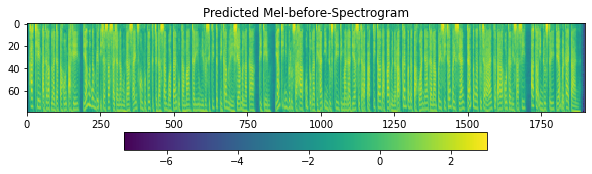

In [20]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

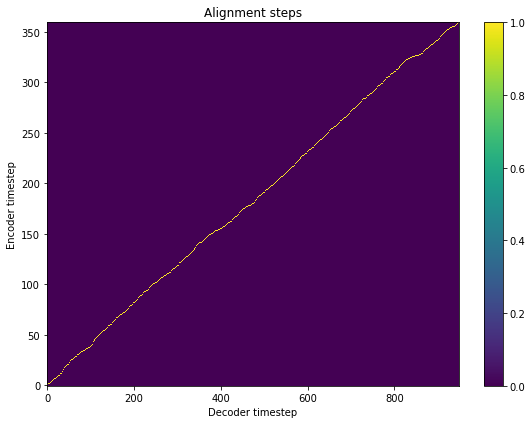

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [22]:
mel = o[0][0] * mel_stat[1] + mel_stat[0]
mel = (mel - MEL_MEAN) / MEL_STD

In [23]:
y_ = vocoder.predict([mel])[0]

In [24]:
import IPython.display as ipd
ipd.Audio(y_, rate = 22050)

In [25]:
saver = tf.train.Saver()
saver.save(sess, 'glowtts-yasmin-output/model.ckpt')

'glowtts-yasmin-output/model.ckpt'

In [26]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'input_ids' in n.name
        or 'lens' in n.name
        or 'temperature' in n.name
        or 'length_ratio' in n.name
        or 'mel_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'AssignVariableOp' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['input_ids',
 'lens',
 'temperature',
 'length_ratio',
 'Variable',
 'Variable_1',
 'Variable_2',
 'Variable_3',
 'Variable_4',
 'Variable_5',
 'Variable_6',
 'Variable_7',
 'Variable_8',
 'Variable_9',
 'Variable_10',
 'Variable_11',
 'Variable_12',
 'Variable_13',
 'Variable_14',
 'Variable_15',
 'Variable_16',
 'Variable_17',
 'Variable_18',
 'Variable_19',
 'Variable_20',
 'Variable_21',
 'Variable_22',
 'Variable_23',
 'Variable_24',
 'Variable_25',
 'Variable_26',
 'Variable_27',
 'Variable_28',
 'Variable_29',
 'Variable_30',
 'Variable_31',
 'Variable_32',
 'Variable_33',
 'Variable_34',
 'Variable_35',
 'embedding/embedding_lookup',
 'model/embedding/embedding_lookup',
 'mel_output',
 'alignment_histories']

In [27]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [28]:
freeze_graph('glowtts-yasmin-output', strings)



INFO:tensorflow:Restoring parameters from glowtts-yasmin-output/model.ckpt
INFO:tensorflow:Froze 627 variables.
INFO:tensorflow:Converted 627 variables to const ops.

8765 ops in the final graph.


In [29]:
import struct

unknown = b'\xff\xff\xff\xff'

def load_graph(frozen_graph_filename, return_def = False):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    for node in graph_def.node:
        if node.op == 'RefSwitch':
            node.op = 'Switch'
            for index in range(len(node.input)):
                if 'moving_' in node.input[index]:
                    node.input[index] = node.input[index] + '/read'
        elif node.op == 'AssignSub':
            node.op = 'Sub'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op == 'AssignAdd':
            node.op = 'Add'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op in ['Assign', 'AssignVariableOp']:
            if node.op == 'AssignVariableOp':
                node.attr.setdefault('T')
                node.attr['T'].type = node.attr['dtype'].type
                del node.attr['dtype']
            node.op = 'Identity'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
            if 'validate_shape' in node.attr:
                del node.attr['validate_shape']
            if len(node.input) == 2:
                node.input[0] = node.input[1]
                del node.input[1]
        elif node.op == 'Switch' and 'wave_net_block' in node.name and 'AssignVariableOp_' in node.name:
            node.attr['T'].type = 1
    
    if return_def:
        return graph_def
    
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [30]:
g = load_graph('glowtts-yasmin-output/frozen_model.pb')

In [31]:
test_sess = tf.InteractiveSession(graph = g)

In [32]:
input_nodes = ['input_ids', 'lens', 'temperature', 'length_ratio']
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}

In [33]:
output_nodes = ['mel_output','alignment_histories']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [34]:
%%time

o = test_sess.run(outputs, feed_dict = {inputs['input_ids']: [ids], 
                                        inputs['lens']: [len(ids)],
                                        inputs['temperature']: 0.3333,
                                        inputs['length_ratio']: 1.0})

CPU times: user 1.85 s, sys: 71.6 ms, total: 1.92 s
Wall time: 750 ms


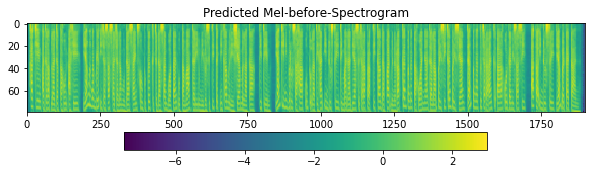

In [35]:
mel_outputs_ = np.reshape(o['mel_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

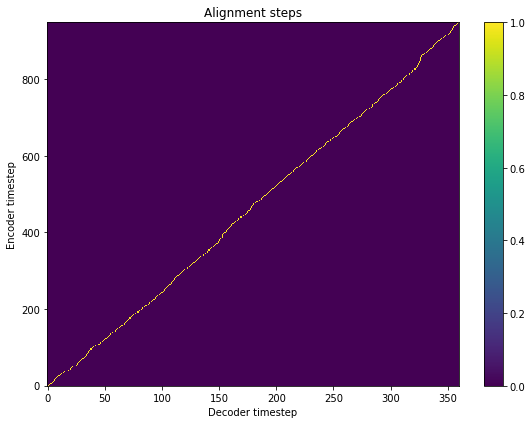

In [36]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o['alignment_histories'][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [37]:
from tensorflow.tools.graph_transforms import TransformGraph

In [38]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [39]:
pb = 'glowtts-yasmin-output/frozen_model.pb'

In [40]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

2022-09-04 11:39:49.771511: I tensorflow/tools/graph_transforms/transform_graph.cc:318] Applying add_default_attributes
2022-09-04 11:39:49.810525: I tensorflow/tools/graph_transforms/transform_graph.cc:318] Applying remove_nodes
2022-09-04 11:39:49.850260: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for mel_output
2022-09-04 11:39:49.850292: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for alignment_histories
2022-09-04 11:39:49.901482: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for mel_output
2022-09-04 11:39:49.901515: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for alignment_histories
2022-09-04 11:39:49.948247: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for mel_output
2022-09-04 11:39:49.948278: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for alignment_histories
2022-09-04 11:39:49.997

In [41]:
g = load_graph('glowtts-yasmin-output/frozen_model.pb.quantized')

In [42]:
test_sess = tf.InteractiveSession(graph = g)
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [43]:
%%time

o = test_sess.run(outputs, feed_dict = {inputs['input_ids']: [ids], 
                                        inputs['lens']: [len(ids)],
                                        inputs['temperature']: 0.3333,
                                        inputs['length_ratio']: 1.0})

CPU times: user 2 s, sys: 124 ms, total: 2.12 s
Wall time: 903 ms


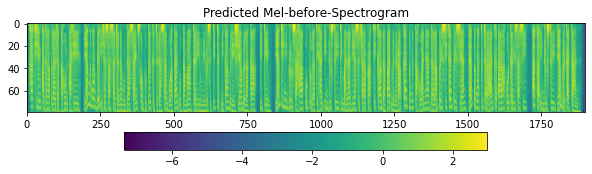

In [44]:
mel_outputs_ = np.reshape(o['mel_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [45]:
from malaya_boilerplate.huggingface import upload_dict

In [46]:
!tar -cvf glowtts-yasmin-output.tar glowtts-yasmin-output

glowtts-yasmin-output/
glowtts-yasmin-output/frozen_model.pb.quantized
glowtts-yasmin-output/frozen_model.pb
glowtts-yasmin-output/model.ckpt.meta
glowtts-yasmin-output/checkpoint
glowtts-yasmin-output/model.ckpt.index
glowtts-yasmin-output/model.ckpt.data-00000-of-00001


In [47]:
files_mapping = {'glowtts-yasmin-output.tar': 'glowtts-yasmin-output.tar'}
upload_dict(model = 'pretrained-glowtts', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: 75hHPSeCoOFbSgEnkusow) - You already created this model repo


In [48]:
files_mapping = {'glowtts-yasmin-output/frozen_model.pb': 'model.pb'}
upload_dict(model = 'text-to-speech-glowtts-yasmin', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: cZbA0hSPv1ZaOo2F-qPGW) - You already created this model repo


In [49]:
files_mapping = {'glowtts-yasmin-output/frozen_model.pb.quantized': 'model.pb'}
upload_dict(model = 'text-to-speech-glowtts-yasmin-quantized', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: 5R_lklDj8ev8XfnGffX2z) - You already created this model repo
